# Trying to create a map of response to all polarisations of GWs

In [73]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from pycbc.detector import Detector, add_detector_on_earth


learning healpy

[0.01701055 0.01701055 0.01701055 ... 3.1245821  3.1245821  3.1245821 ] [0.78539816 2.35619449 3.92699082 ... 2.35619449 3.92699082 5.49778714]


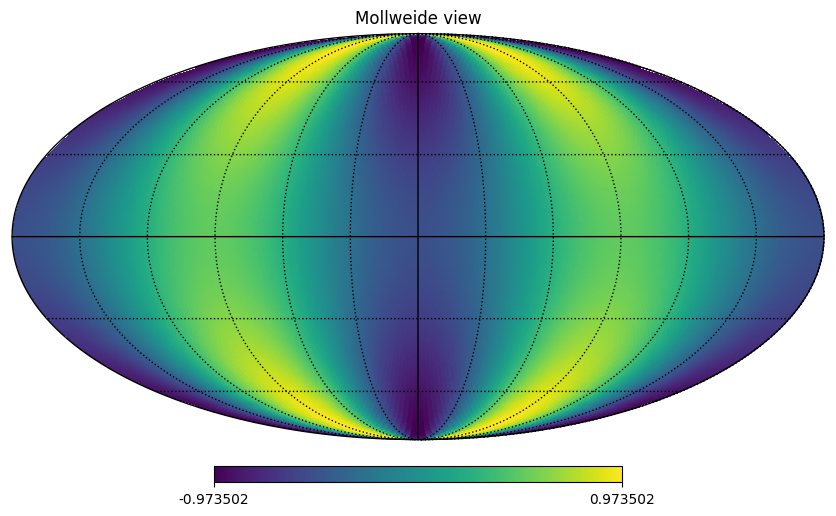

In [74]:
NSIDE = 48
NPIX = hp.nside2npix(NSIDE)

psi = 0

thetas, phis = hp.pix2ang(NSIDE, [x for x in range(0,NPIX)])

print(thetas, phis)

m = -0.5 * (1 + np.cos(thetas)**2) * np.cos(2 * phis) * np.cos(2 * psi) - np.cos(thetas) * np.sin(2 * phis) * np.sin(2*psi)

hp.mollview(m)
hp.graticule()

## Calculation time
This is all going to be in the co-rotating frame with the earth
To do:
- work out detector tensor in co-rotating frame
- work out wave tensor in co-rotating frame
- test against pycbc

In [75]:
#used chatgpt as this is trivial and I cba to write good docs
def detector_tensor_earthfixed(lat_rad, lon_rad, arm1_az_rad, arm2_az_rad, return_position=True):
    """
    Compute the detector tensor for a ground-based interferometer 
    in the Earth-fixed Cartesian basis {earth_x, earth_y, earth_z}.

    Parameters
    ----------
    lat_rad : float
        Latitude in radians (+north)
    lon_rad : float
        Longitude in radians (+east)
    arm1_az_rad : float
        Azimuth of first arm in radians (clockwise from North)
    arm2_az_rad : float
        Azimuth of second arm in radians (clockwise from North)
    return_position : bool, optional
        If True, also return the detector position vector (Earth-fixed basis)

    Returns
    -------
    d_matrix : (3,3) ndarray
        Detector tensor components in Earth-fixed Cartesian basis
    arm1_vec, arm2_vec : (3,) ndarray
        Unit vectors of the detector arms in Earth-fixed basis
    position_vec : (3,) ndarray, optional
        Position vector (unit radius) in Earth-fixed basis
    """
    # --- Global Earth-fixed Cartesian basis (fixed to Earth) ---
    earth_x = np.array([1.0, 0.0, 0.0])  # points to (lat=0°, lon=0°)
    earth_y = np.array([0.0, 1.0, 0.0])  # points to (lat=0°, lon=90°E)
    earth_z = np.array([0.0, 0.0, 1.0])  # points to North Pole

    # --- Detector position vector (on unit sphere) ---
    position_vec = (np.cos(lat_rad)*np.cos(lon_rad) * earth_x +
                    np.cos(lat_rad)*np.sin(lon_rad) * earth_y +
                    np.sin(lat_rad) * earth_z)

    # --- Local horizontal directions (in Earth-fixed coordinates) ---
    east = -np.sin(lon_rad)*earth_x + np.cos(lon_rad)*earth_y
    north = (-np.sin(lat_rad)*np.cos(lon_rad))*earth_x \
            + (-np.sin(lat_rad)*np.sin(lon_rad))*earth_y \
            + np.cos(lat_rad)*earth_z

    # --- Compute horizontal arm direction vectors ---
    arm1_vec = np.cos(arm1_az_rad)*north + np.sin(arm1_az_rad)*east
    arm2_vec = np.cos(arm2_az_rad)*north + np.sin(arm2_az_rad)*east

    arm1_vec /= np.linalg.norm(arm1_vec)
    arm2_vec /= np.linalg.norm(arm2_vec)

    # --- Detector tensor ---
    d_matrix = 0.5 * (np.outer(arm1_vec, arm1_vec) - np.outer(arm2_vec, arm2_vec))

    if return_position:
        return d_matrix, arm1_vec, arm2_vec, position_vec
    else:
        return d_matrix, arm1_vec, arm2_vec


Tests

In [76]:
# LIGO-like site at 30° N, 90° W
lat = np.radians(30.0)
lon = np.radians(-90.0)

# Arms: West (270°) and South (180°)
arm1_az = np.radians(270.0)
arm2_az = np.radians(180.0)

d, arm1_vec, arm2_vec, pos = detector_tensor_earthfixed(lat, lon, arm1_az, arm2_az)

print("Arm 1 (West) =", arm1_vec)
print("Arm 2 (South) =", arm2_vec)
print("Detector tensor =\n", d)
print("Detector position =", pos)


Arm 1 (West) = [-1.00000000e+00 -1.53080850e-16 -1.59086286e-16]
Arm 2 (South) = [ 1.53080850e-16 -5.00000000e-01 -8.66025404e-01]
Detector tensor =
 [[ 5.00000000e-01  1.14810637e-16  1.45829095e-16]
 [ 1.14810637e-16 -1.25000000e-01 -2.16506351e-01]
 [ 1.45829095e-16 -2.16506351e-01 -3.75000000e-01]]
Detector position = [ 5.30287619e-17 -8.66025404e-01  5.00000000e-01]


Calculating incoming wave matrix

HAVENT ADDED ROTATION TO NON-GR MODES YET

In [77]:

def _normalize(v):
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero-length vector")
    return v / n


def _k_from_radec(ra_rad, dec_rad, gst_rad):
    """Propagation direction k (Earth-fixed) from RA, Dec, and GST."""
    H = gst_rad - ra_rad  # hour angle
    kx = -np.cos(dec_rad) * np.cos(H)
    ky = -np.cos(dec_rad) * np.sin(H)
    kz = -np.sin(dec_rad)
    return _normalize(np.array([kx, ky, kz]))


def _build_i_j_from_k(k_vec):
    """Construct orthonormal basis vectors (i, j) ⟂ k."""
    earth_z = np.array([0.0, 0.0, 1.0])
    i_vec = np.cross(earth_z, k_vec)
    if np.linalg.norm(i_vec) < 1e-8:
        earth_x = np.array([1.0, 0.0, 0.0])
        i_vec = np.cross(earth_x, k_vec)
    i_vec = _normalize(i_vec)
    j_vec = _normalize(np.cross(k_vec, i_vec))
    return i_vec, j_vec


def wave_polarization_tensors(
    ra_rad=None,
    dec_rad=None,
    gst_rad=None,
    k_vec=None,
    psi_rad=0.0,
    include_nonGR=False
):
    """
    Compute gravitational-wave polarization tensors in the Earth-fixed Cartesian basis.

    Parameters
    ----------
    ra_rad, dec_rad : float or None
        Right ascension and declination (radians). Requires gst_rad.
    gst_rad : float or None
        Greenwich Sidereal Time (radians). Only needed if ra/dec provided.
    k_vec : array-like or None
        Direct wave propagation vector in Earth-fixed basis (3,).
        If provided, RA/Dec/GST are ignored.
    psi_rad : float
        Polarization angle in radians.
    include_nonGR : bool
        If True, also return rotated non-GR polarization tensors:
        'vector_x', 'vector_y', 'breathing', 'longitudinal'.

    Returns
    -------
    tensors : dict
        {
          'k' : (3,) propagation vector,
          'i' : (3,) polarization basis vector,
          'j' : (3,) polarization basis vector,
          'e_plus' : (3,3),
          'e_cross' : (3,3),
          'vector_x' : (3,3),  # optional
          'vector_y' : (3,3),
          'breathing' : (3,3),
          'longitudinal' : (3,3)
        }
        All tensors are rotated by psi.
    """
    # Determine propagation vector k
    if k_vec is None:
        if ra_rad is None or dec_rad is None or gst_rad is None:
            raise ValueError("Provide either (ra_rad, dec_rad, gst_rad) or k_vec.")
        k = _k_from_radec(ra_rad, dec_rad, gst_rad)
    else:
        k = _normalize(np.array(k_vec, dtype=float))

    # Build orthonormal triad (i, j, k)
    i_vec, j_vec = _build_i_j_from_k(k)

    # Construct unrotated tensors
    e_plus = np.outer(i_vec, i_vec) - np.outer(j_vec, j_vec)
    e_cross = np.outer(i_vec, j_vec) + np.outer(j_vec, i_vec)

    # Non-GR tensors (unrotated)
    if include_nonGR:
        vector_x = np.outer(i_vec, k) + np.outer(k, i_vec)
        vector_y = np.outer(j_vec, k) + np.outer(k, j_vec)
        breathing = np.outer(i_vec, i_vec) + np.outer(j_vec, j_vec)
        longitudinal = np.outer(k, k)

    # Rotate the (i, j) basis by polarization angle ψ around k
    cpsi, spsi = np.cos(psi_rad), np.sin(psi_rad)
    i_rot = cpsi * i_vec + spsi * j_vec
    j_rot = -spsi * i_vec + cpsi * j_vec

    # Rebuild tensors in rotated frame
    e_plus_rot = np.outer(i_rot, i_rot) - np.outer(j_rot, j_rot)
    e_cross_rot = np.outer(i_rot, j_rot) + np.outer(j_rot, i_rot)

    tensors = {
        "k": k,
        "i": i_rot,
        "j": j_rot,
        "e_plus": e_plus_rot,
        "e_cross": e_cross_rot,
    }

    # Rotate non-GR tensors accordingly
    if include_nonGR:
        vector_x_rot = np.outer(i_rot, k) + np.outer(k, i_rot)
        vector_y_rot = np.outer(j_rot, k) + np.outer(k, j_rot)
        breathing_rot = np.outer(i_rot, i_rot) + np.outer(j_rot, j_rot)
        longitudinal_rot = np.outer(k, k)
        tensors.update({
            "vector_x": vector_x_rot,
            "vector_y": vector_y_rot,
            "breathing": breathing_rot,
            "longitudinal": longitudinal_rot,
        })

    return tensors



Tests

In [90]:
ra = np.radians(0.0)        # RA = 0
dec = np.radians(60.0)      # Dec = +60 deg
gst = np.radians(0.0)       # Greenwich Sidereal Time (radians)

tensors = wave_polarization_tensors(ra_rad=ra, dec_rad=dec, gst_rad=gst, psi_rad=0)
e_plus = tensors['e_plus']
e_cross = tensors['e_cross']
k_vec = tensors['k']

print(e_plus)
print(e_cross)
print(k_vec)


[[-0.75       0.         0.4330127]
 [ 0.         1.        -0.       ]
 [ 0.4330127 -0.        -0.25     ]]
[[-0.         0.8660254  0.       ]
 [ 0.8660254 -0.        -0.5      ]
 [ 0.        -0.5        0.       ]]
[-0.5       -0.        -0.8660254]


## Calculate Response

In [79]:
def calculate_response(detector_tensor, wave_tensors):
    return np.tensordot(detector_tensor, wave_tensors)

In [80]:
# LIGO-like site at 30° N, 90° W
lat = np.radians(20.0)
lon = np.radians(-90.0)

# Arms: West (270°) and South (180°)
arm1_az = np.radians(270.0)
arm2_az = np.radians(180.0)

d, arm1_vec, arm2_vec, pos = detector_tensor_earthfixed(lat, lon, arm1_az, arm2_az)

tensors = wave_polarization_tensors(ra_rad=ra, dec_rad=dec, gst_rad=gst, psi_rad=0.0)
e_plus_rot = tensors['e_plus']
e_cross_rot = tensors['e_cross']

print(calculate_response(d,e_plus_rot))


-0.32311111152531913


[  1.16956551   1.16956551   1.16956551 ... 178.83043449 178.83043449
 178.83043449] [ 45. 135. 225. ... 135. 225. 315.]
19200
[np.float64(0.13969106744155146), np.float64(0.7322174793965068), np.float64(0.13969106744155152), np.float64(0.7322174793965074), np.float64(0.22823666004724566), np.float64(0.25358788546063615), np.float64(0.7433264346977762), np.float64(0.548419808944965), np.float64(0.22823666004724563), np.float64(0.25358788546063604), np.float64(0.7433264346977767), np.float64(0.5484198089449654), np.float64(0.27473103553633976), np.float64(0.15542279294036354), np.float64(0.3390976717189962), np.float64(0.6917961777169345), np.float64(0.7081751555270688), np.float64(0.47478489212510655), np.float64(0.2747310355363399), np.float64(0.1554227929403636), np.float64(0.33909767171899624), np.float64(0.6917961777169339), np.float64(0.7081751555270687), np.float64(0.4747848921251066), np.float64(0.29563960467004247), np.float64(0.18583652404360013), np.float64(0.1861153005940567

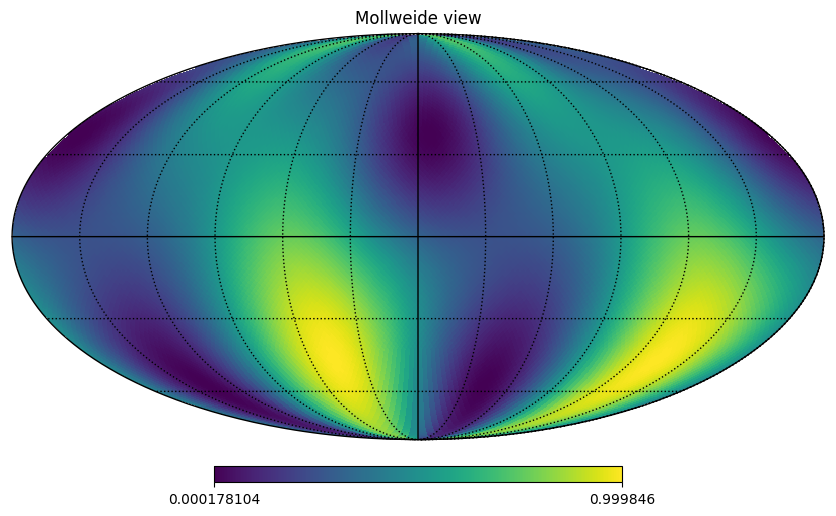

In [117]:
NSIDE = 40
NPIX = hp.nside2npix(NSIDE)
psi = 1.5

thetas, phis = hp.pix2ang(NSIDE, [x for x in range(0,NPIX)])

print(np.degrees(thetas),np.degrees(phis))

# LIGO-like site at 30° N, 90° W
lat = 0.8107952638300001
lon = -2.084056769170001

# Arms: West (270°) and South (180°)
arm1_az = np.radians(324.0)
arm2_az = np.radians(234.0)

d, arm1_vec, arm2_vec, pos = detector_tensor_earthfixed(lat, lon, arm1_az, arm2_az)
responses = []

for theta, phi in zip(thetas,phis):
        responses.append(calculate_response(d,wave_polarization_tensors(ra_rad=theta, dec_rad=phi, gst_rad=gst, psi_rad=psi)['e_plus'])**2
                  +calculate_response(d,wave_polarization_tensors(ra_rad=theta, dec_rad=phi, gst_rad=gst, psi_rad=psi)['e_cross'])**2)

print(len(responses))

print(responses)

hp.mollview(np.array(responses))
hp.graticule()


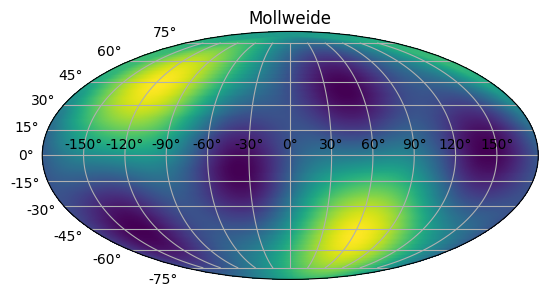

In [107]:
#sample code from pycbc for h1

ra, dec = np.meshgrid(np.arange(0, np.pi*2.0, .01), 
                      np.arange(-np.pi / 2.0, np.pi / 2.0, .01))
ra = ra.flatten()
dec = dec.flatten()

pol = 0
time = 1e10+6950

h1 = Detector("H1")
fp, fc = h1.antenna_pattern(ra, dec, pol, time)

plt.figure()
plt.subplot(111, projection="mollweide")
ra[ra>np.pi] -= np.pi * 2.0
plt.scatter(ra, dec, c=fp**2 + fc**2)
plt.title("Mollweide")
plt.grid(True)
plt.show()

In [88]:
#debugging by looking at how pycbc handles things

h1 = Detector("H1", reference_time=0)
print(h1.location/np.linalg.norm(h1.location))
print(np.degrees(h1.info["xangle"]))
print(np.degrees(h1.info["yangle"]))

lat = h1.latitude
lon = h1.longitude

# Arms: West (270°) and South (180°)
arm1_az = np.radians(324)
arm2_az = np.radians(234)

d, arm1_vec, arm2_vec, pos = detector_tensor_earthfixed(lat, lon, arm1_az, arm2_az)
print(pos/np.linalg.norm(pos))

[-0.33946673 -0.60226818  0.72252016]
324.00059641239
234.00058707772268
[-0.33827471 -0.60015335  0.72483528]


In [120]:
##pulling out some source code
import numpy as np
from math import cos, sin

def wave_tensors_from_pycbc_style(ra, dec, psi, t_gps, detector):
    """
    Construct wave polarization tensors in Earth-fixed basis at GPS time t_gps,
    following the same logic as PyCBC's Detector.antenna_pattern method.

    Parameters
    ----------
    ra : float
        Right ascension of source (radians)
    dec : float
        Declination of source (radians)
    psi : float
        Polarization angle of source (radians)
    t_gps : float
        GPS time (seconds)
    response_matrix : (3,3) ndarray
        Detector response matrix in Earth-fixed basis (this encodes the detector tensor geometry)

    Returns
    -------
    k_vec : (3,) ndarray
        Propagation direction (Earth-fixed)
    i_rot : (3,) ndarray
        Rotated basis vector i (Earth-fixed)
    j_rot : (3,) ndarray
        Rotated basis vector j (Earth-fixed)
    e_plus : (3,3) ndarray
        Plus polarization tensor (Earth-fixed)
    e_cross : (3,3) ndarray
        Cross polarization tensor (Earth-fixed)
    """
    # 1) Compute GMST → hour angle (simplified; you may need the full gmst_estimate)
    # In PyCBC: gha = gmst_estimate(t_gps) - ra
    # For now assume a function gmst = f(t_gps) is available or pass it in
    # Here we just placeholder: gha = ...
    # You must supply or compute gmst_estimate(t_gps) separately.
    #raise NotImplementedError("You must compute or pass gmst_estimate(t_gps) here.")

    gmst = detector.gmst_estimate(t_gps)
    response_matrix = detector.response

    gha = gmst - ra
    cosgha = cos(gha)
    singha = sin(gha)
    cosdec = cos(dec)
    sindec = sin(dec)

    # 2) Build source unit vector in Earth-fixed frame (this is like “nhat” in PyCBC)
    # PyCBC: e0, e1, e2 components
    k_vec = np.array([
        -cosdec * cosgha,
        -cosdec * singha,
        -sindec
    ])

    # 3) Build basis vectors for polarizations
    x0 = -cos(psi) * singha - sin(psi) * cosgha * sindec
    x1 = -cos(psi) * cosgha + sin(psi) * singha * sindec
    x2 =  sin(psi) * cosdec
    x = np.array([x0, x1, x2])

    y0 =  sin(psi) * singha - cos(psi) * cosgha * sindec
    y1 =  sin(psi) * cosgha + cos(psi) * singha * sindec
    y2 =  cos(psi) * cosdec
    y = np.array([y0, y1, y2])

    # 4) Transform using the detector response matrix
    dx = response_matrix.dot(x)
    dy = response_matrix.dot(y)

    # 5) Construct tensors: note PyCBC uses contraction on vectors x, dx etc to build F+ and Fx
    # But we want explicit tensors:
    # We derive i_rot, j_rot from x, y and response—not trivial but we can approximate:
    # Here: treat x, y as basis for polarization plane, then
    # i_rot = ‖x‖-normalized, j_rot = ‖y‖-normalized orthonormal to i_rot
    i_rot = x / np.linalg.norm(x)
    j_rot = y / np.linalg.norm(y)

    e_plus = np.outer(i_rot, i_rot) - np.outer(j_rot, j_rot)
    e_cross = np.outer(i_rot, j_rot) + np.outer(j_rot, i_rot)

    return k_vec, i_rot, j_rot, e_plus, e_cross




ra = np.radians(0.0)        # RA = 0
dec = np.radians(60.0)      # Dec = +60 deg
gst = 1e10+6950 # Greenwich Sidereal Time (radians)

k, i, j, e_plus, e_cross = wave_tensors_from_pycbc_style(ra, dec, 0, gst, Detector("H1"))

print(e_plus)
print(e_cross)
print(k)

[[-7.49997606e-01 -2.04680668e-03  4.33012406e-01]
 [-2.04680668e-03  9.99997606e-01  5.06453655e-04]
 [ 4.33012406e-01  5.06453655e-04 -2.50000000e-01]]
[[-2.02581324e-03  8.66023034e-01  5.84802309e-04]
 [ 8.66023034e-01  2.02581324e-03 -4.99999658e-01]
 [ 5.84802309e-04 -4.99999658e-01  0.00000000e+00]]
[-4.99999658e-01  5.84802309e-04 -8.66025404e-01]


[[-0.75       0.         0.4330127]
 [ 0.         1.        -0.       ]
 [ 0.4330127 -0.        -0.25     ]]
[[-0.         0.8660254  0.       ]
 [ 0.8660254 -0.        -0.5      ]
 [ 0.        -0.5        0.       ]]
[-0.5       -0.        -0.8660254]

In [114]:
print(h1.response)
print(d)

[[-0.39261404 -0.07761352 -0.2473891 ]
 [-0.07761352  0.31952407  0.22799779]
 [-0.2473891   0.22799779  0.07308997]]
[[-0.39255899 -0.07765993 -0.2475054 ]
 [-0.07765993  0.31922713  0.22807228]
 [-0.2475054   0.22807228  0.07333187]]


ping
